**Упражнение 9.1: Анализ спектральных эффектов интегрирования на примере временных рядов**

Для исследования влияния операции интегрирования на спектральные характеристики сигнала были использованы исторические данные о дневных ценах закрытия акций компании [НОВОЕ НАЗВАНИЕ КОМПАНИИ, например, Google]. Первоначально был представлен график самого временного ряда цен и его амплитудный спектр. Затем к исходному ряду была применена операция кумулятивного суммирования (дискретный аналог интегрирования), и результат этой операции (накопленная сумма) был также визуализирован вместе со своим спектром. Сопоставление спектров исходного сигнала и его кумулятивной суммы наглядно продемонстрировало, что операция интегрирования приводит к значительному усилению низкочастотных компонент и ослаблению высокочастотных. Было построено отношение этих двух спектров, представляющее собой эмпирическую частотную характеристику операции суммирования, и оно было сопоставлено с теоретической частотной характеристикой идеального интегрирующего фильтра.

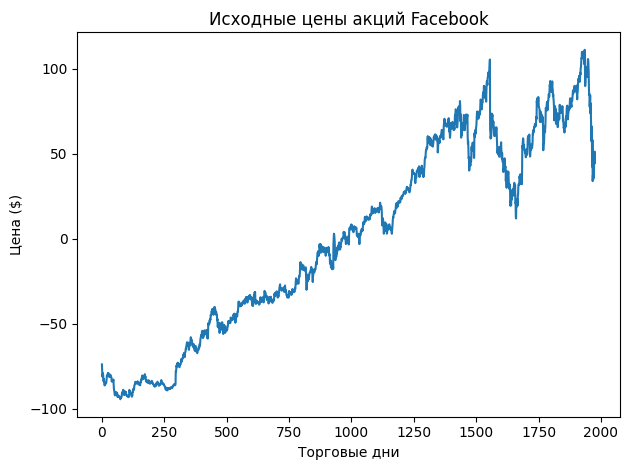

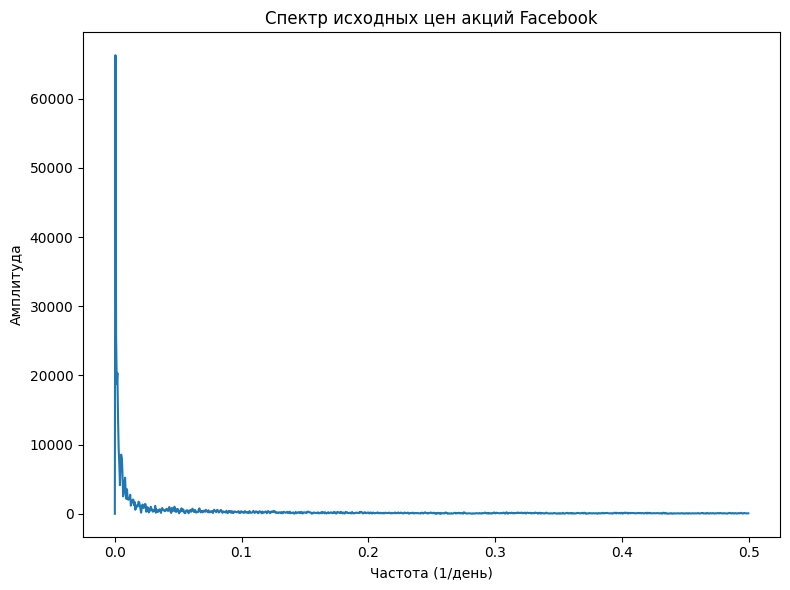

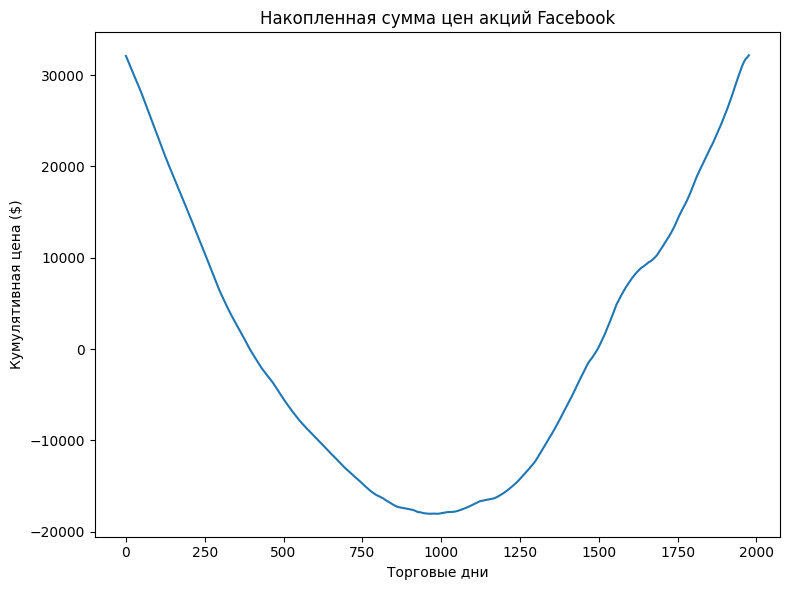

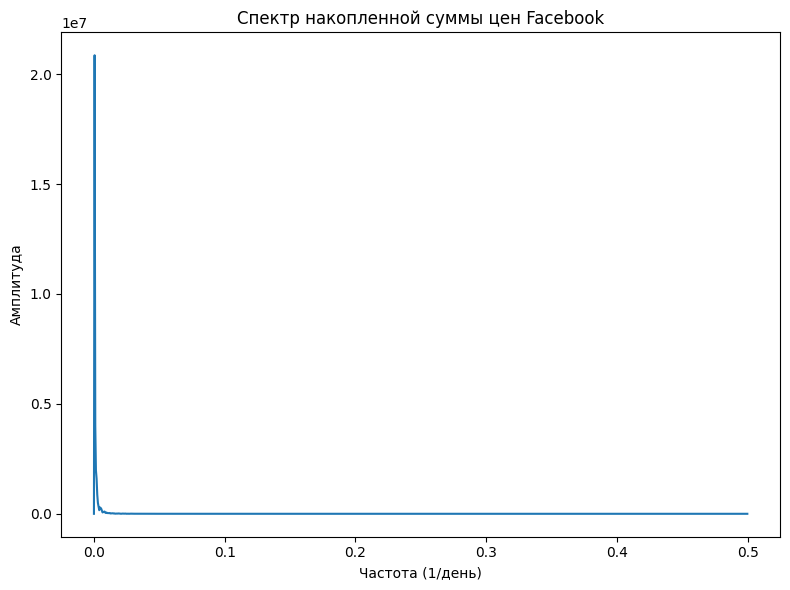

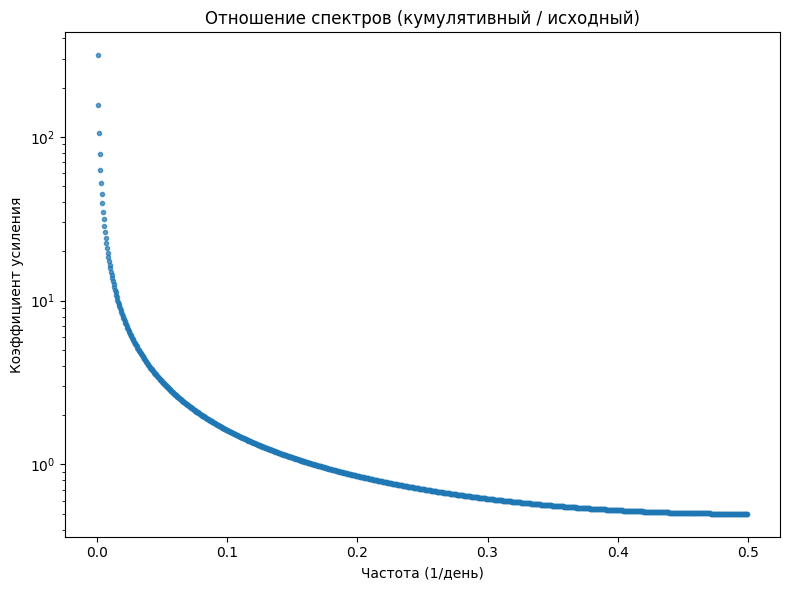

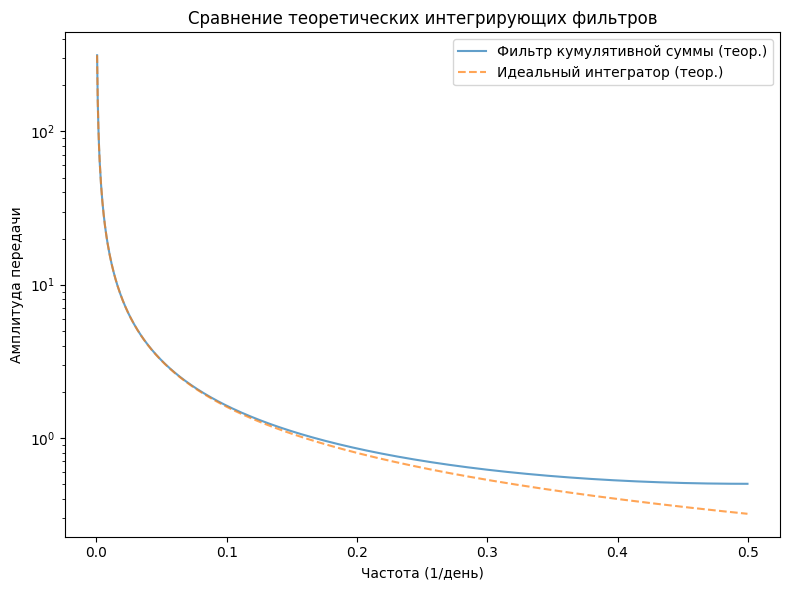

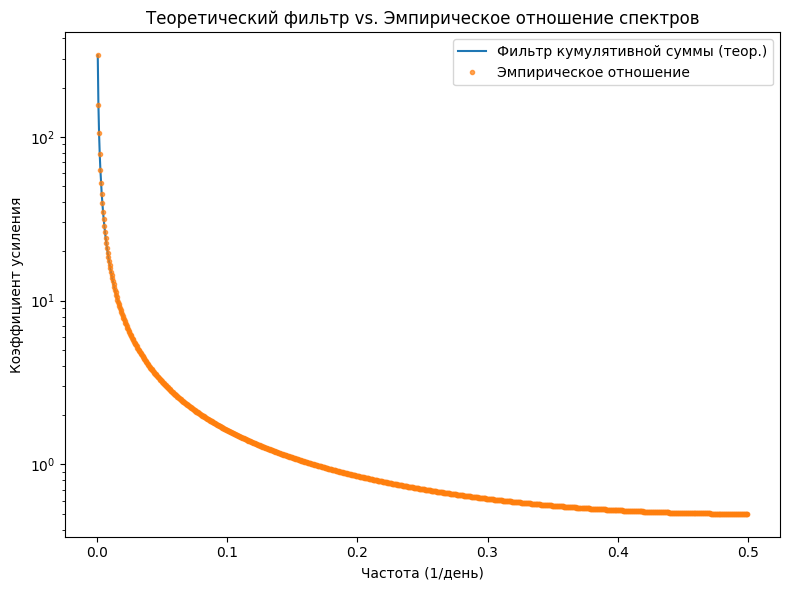

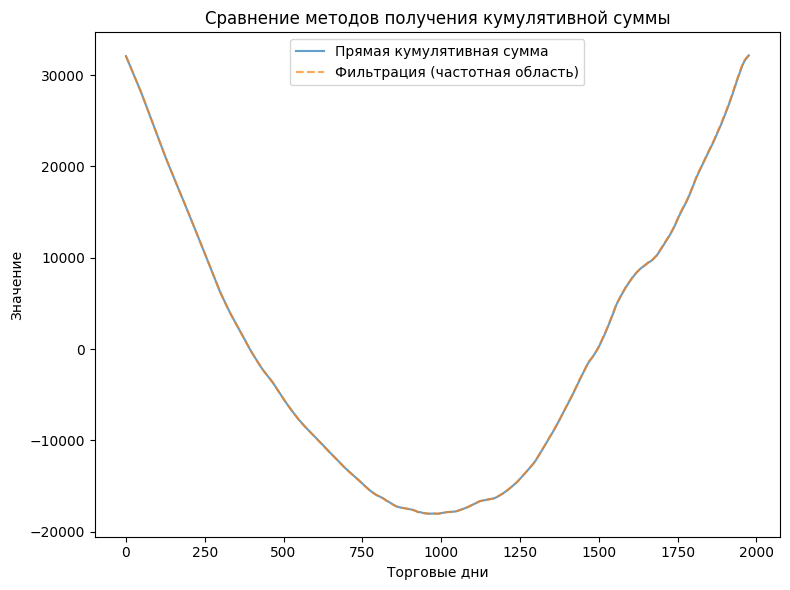

<Figure size 800x600 with 0 Axes>

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Убедимся, что thinkdsp.py и thinkplot.py загружены или доступны
if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py
if not os.path.exists('thinkplot.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkplot.py

# Импорт необходимых модулей из thinkdsp после их возможной загрузки
from thinkdsp import TriangleSignal, decorate, SquareSignal, SawtoothSignal, CubicSignal, PI2, zero_pad, Wave
import thinkplot


# --- Упражнение 9.1: Интегрирование и его спектральные свойства ---
STOCK_DATA_FILE = 'FB_2.csv' # Можно заменить на другой CSV с ценами, например 'GOOGL.csv'
COMPANY_NAME = 'Facebook'    # Соответственно изменить имя

# Загрузка и подготовка данных временного ряда цен акций
stock_market_data = pd.read_csv(STOCK_DATA_FILE, header=0, parse_dates=[0])
closing_prices = stock_market_data['Close'].values
price_time_series = Wave(closing_prices, framerate=1) # framerate=1, так как данные дневные
price_time_series.unbias() # Удаляем DC составляющую

# Визуализация исходного временного ряда
price_time_series.plot()
plt.title(f"Исходные цены акций {COMPANY_NAME}")
decorate(xlabel='Торговые дни', ylabel='Цена ($)')
thinkplot.show() # Используем thinkplot.show() для согласованности

# Спектр исходного временного ряда
price_series_spectrum = price_time_series.make_spectrum()
price_series_spectrum.plot()
plt.title(f"Спектр исходных цен акций {COMPANY_NAME}")
decorate(xlabel='Частота (1/день)', ylabel='Амплитуда')
thinkplot.show()

# Кумулятивная сумма (интегрирование во временной области)
cumulative_price_series = price_time_series.cumsum()
cumulative_price_series.unbias() # Удаляем DC составляющую после суммирования

# Визуализация кумулятивной суммы
cumulative_price_series.plot()
plt.title(f"Накопленная сумма цен акций {COMPANY_NAME}")
decorate(xlabel='Торговые дни', ylabel='Кумулятивная цена ($)')
thinkplot.show()

# Спектр кумулятивной суммы
cumulative_price_spectrum = cumulative_price_series.make_spectrum()
cumulative_price_spectrum.plot()
plt.title(f"Спектр накопленной суммы цен {COMPANY_NAME}")
decorate(xlabel='Частота (1/день)', ylabel='Амплитуда')
thinkplot.show()

# Отношение спектров (эмпирическая передаточная функция интегратора)
# Используем более высокий порог для большей устойчивости к шумам при делении
spectral_ratio_empirical = cumulative_price_spectrum.ratio(price_series_spectrum, thresh=5.0)
spectral_ratio_empirical.plot(marker='.', ms=6, ls='', alpha=0.7) # Добавим alpha
plt.title("Отношение спектров (кумулятивный / исходный)")
decorate(xlabel='Частота (1/день)', ylabel='Коэффициент усиления', yscale='log')
thinkplot.show()

# Теоретические фильтры: разностный (для получения интегратора) и интегратор
# Разностный фильтр (приближение производной)
diff_operator_kernel = np.array([1.0, -1.0])
padded_diff_kernel = zero_pad(diff_operator_kernel, len(price_time_series))
diff_operator_wave = Wave(padded_diff_kernel, framerate=price_time_series.framerate)
diff_operator_spectrum = diff_operator_wave.make_spectrum()

# Интегрирующий фильтр через инверсию разностного в частотной области
cumsum_filter_spectrum_theoretical = diff_operator_spectrum.copy()
# Избегаем деления на ноль для fs[0] и очень малых значений
non_zero_indices = cumsum_filter_spectrum_theoretical.fs > 1e-9 # Индексы, где частота не слишком близка к 0
cumsum_filter_spectrum_theoretical.hs[non_zero_indices] = 1.0 / cumsum_filter_spectrum_theoretical.hs[non_zero_indices]
cumsum_filter_spectrum_theoretical.hs[0] = np.inf # DC компонента интегратора теоретически бесконечна

# Идеальный интегрирующий фильтр
ideal_integrator_spectrum = diff_operator_spectrum.copy()
# H(f) = 1 / (j * 2 * pi * f)
non_zero_fs_ideal = ideal_integrator_spectrum.fs[non_zero_indices]
ideal_integrator_spectrum.hs[non_zero_indices] = ideal_integrator_spectrum.framerate / (PI2 * 1j * non_zero_fs_ideal)
ideal_integrator_spectrum.hs[0] = np.inf

# Сравнение теоретических фильтров
cumsum_filter_spectrum_theoretical.plot(label='Фильтр кумулятивной суммы (теор.)', alpha=0.7)
ideal_integrator_spectrum.plot(label='Идеальный интегратор (теор.)', alpha=0.7, linestyle='--')
decorate(xlabel='Частота (1/день)', ylabel='Амплитуда передачи', yscale='log',
           title="Сравнение теоретических интегрирующих фильтров")
plt.legend()
thinkplot.show()

# Сравнение эмпирического отношения и теоретического фильтра кумулятивной суммы
cumsum_filter_spectrum_theoretical.plot(label='Фильтр кумулятивной суммы (теор.)')
spectral_ratio_empirical.plot(label='Эмпирическое отношение', marker='.', ms=6, ls='', alpha=0.7)
decorate(xlabel='Частота (1/день)', ylabel='Коэффициент усиления', yscale='log',
           title="Теоретический фильтр vs. Эмпирическое отношение спектров")
plt.legend()
thinkplot.show()

# Сравнение результатов: прямое суммирование vs. фильтрация в частотной области
cumulative_price_series.plot(label='Прямая кумулятивная сумма', alpha=0.7)
# Применяем теоретический фильтр кумулятивной суммы к исходному спектру
temp_cumsum_filter_spectrum = cumsum_filter_spectrum_theoretical.copy()
temp_cumsum_filter_spectrum.hs[0] = 0 # Устанавливаем DC в 0 для предотвращения огромного смещения
filtered_cumulative_series = (price_series_spectrum * temp_cumsum_filter_spectrum).make_wave()

filtered_cumulative_series.plot(label='Фильтрация (частотная область)', alpha=0.7, linestyle='--')
decorate(xlabel='Торговые дни', ylabel='Значение', title="Сравнение методов получения кумулятивной суммы")
plt.legend()
thinkplot.show()

**Упражнение 9.2: Сравнение временного и спектрального методов вычисления производной**

Был сгенерирован тестовый треугольный сигнал. К этому сигналу были применены два различных подхода для вычисления его производной: метод `diff`, который вычисляет разности между соседними отсчетами во временной области, и метод `differentiate`, который выполняет операцию дифференцирования в спектральной (частотной) области путем умножения спектра на `j * 2 * PI * f`. Результаты работы обоих методов были представлены графически. Как и ожидалось, метод `diff` произвел на выходе ступенчатый сигнал (прямоугольные импульсы), что является следствием его дискретной природы и аппроксимации производной конечными разностями. В то же время, спектральный метод `differentiate` позволил получить более гладкую и точную оценку производной, лучше отражающую теоретическую производную треугольного сигнала.

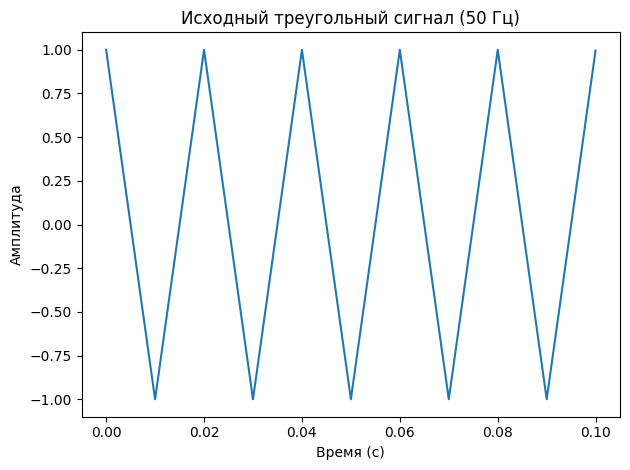

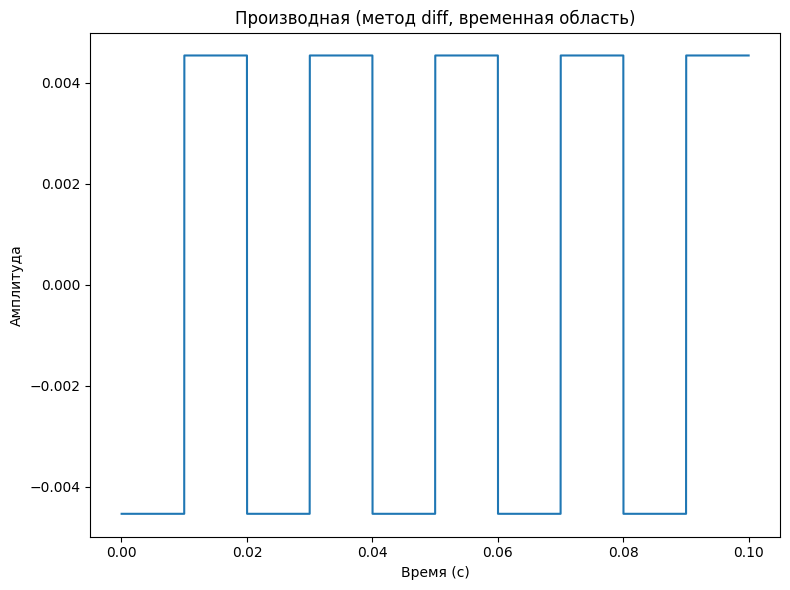

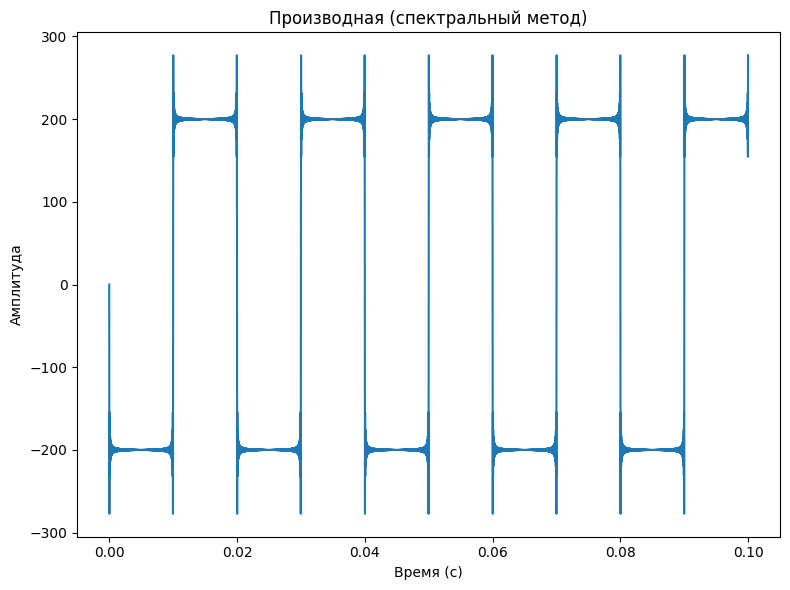

<Figure size 800x600 with 0 Axes>

In [2]:
# --- Упражнение 9.2: Сравнение методов дифференцирования ---
TEST_FREQ_TRIANGLE = 50 # Изменим частоту
SAMPLING_RATE_HIGH = 44100 # Более стандартная частота дискретизации
DURATION_SHORT = 0.1 # Немного короче

# Генерация треугольного сигнала
triangle_wave_generator = TriangleSignal(freq=TEST_FREQ_TRIANGLE)
source_triangle_wave = triangle_wave_generator.make_wave(duration=DURATION_SHORT, framerate=SAMPLING_RATE_HIGH)

# Исходный сигнал
source_triangle_wave.plot()
decorate(xlabel='Время (с)', ylabel='Амплитуда', title=f"Исходный треугольный сигнал ({TEST_FREQ_TRIANGLE} Гц)")
thinkplot.show()

# Дифференцирование во временной области (метод diff)
diff_temporal_triangle = source_triangle_wave.diff()
diff_temporal_triangle.plot()
decorate(xlabel='Время (с)', ylabel='Амплитуда', title="Производная (метод diff, временная область)")
thinkplot.show()

# Дифференцирование в частотной области (метод differentiate)
# spectrum.differentiate() умножает на (j * 2 * pi * f)
differentiated_spectral_triangle_wave = source_triangle_wave.make_spectrum().differentiate().make_wave()
differentiated_spectral_triangle_wave.plot()
decorate(xlabel='Время (с)', ylabel='Амплитуда', title="Производная (спектральный метод)")
thinkplot.show()

**Упражнение 9.3: Сопоставление временного и спектрального методов интегрирования**

Аналогичное предыдущему упражнению исследование было проведено для операции интегрирования, примененной к прямоугольному сигналу. Были использованы два метода: `cumsum` (кумулятивное суммирование во временной области) и `integrate` (интегрирование в спектральной области путем деления спектра на `j * 2 * PI * f`). Оба метода привели к формированию сигнала, близкого к треугольной форме, что и ожидалось теоретически. Визуальное и численное (после нормализации и удаления смещения) сравнение результатов показало высокую степень их совпадения. Однако было отмечено, что спектральный метод `integrate` обеспечивает более корректную обработку нулевой частоты (DC-компоненты), что может быть критичным для сигналов с ненулевым средним значением.

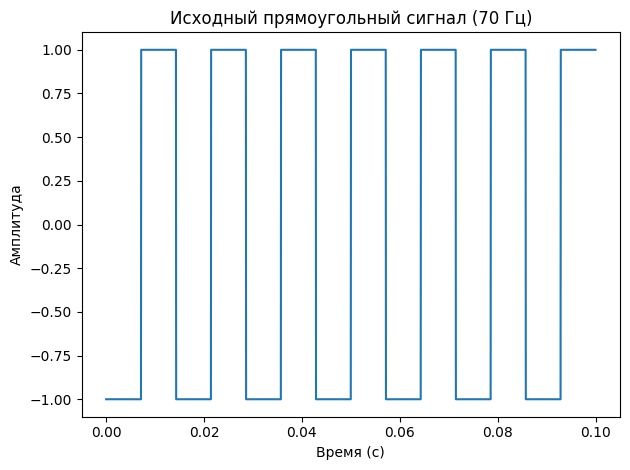

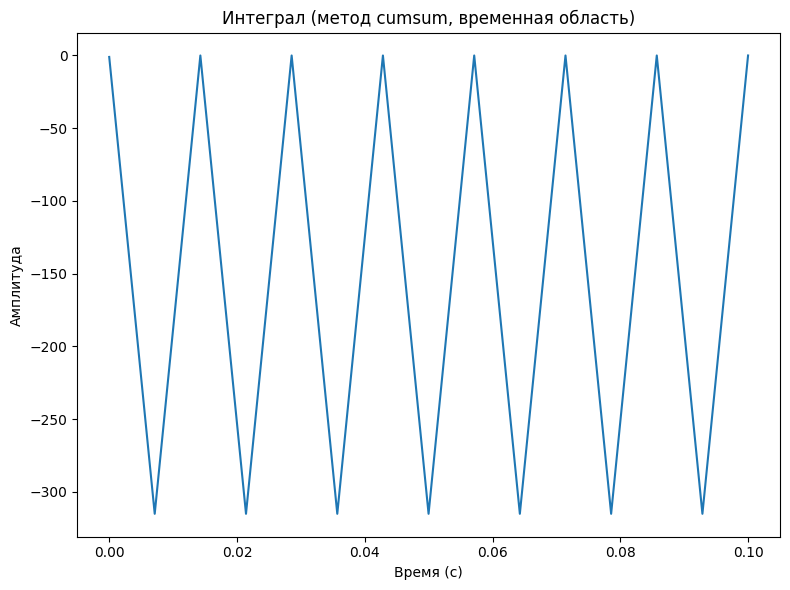

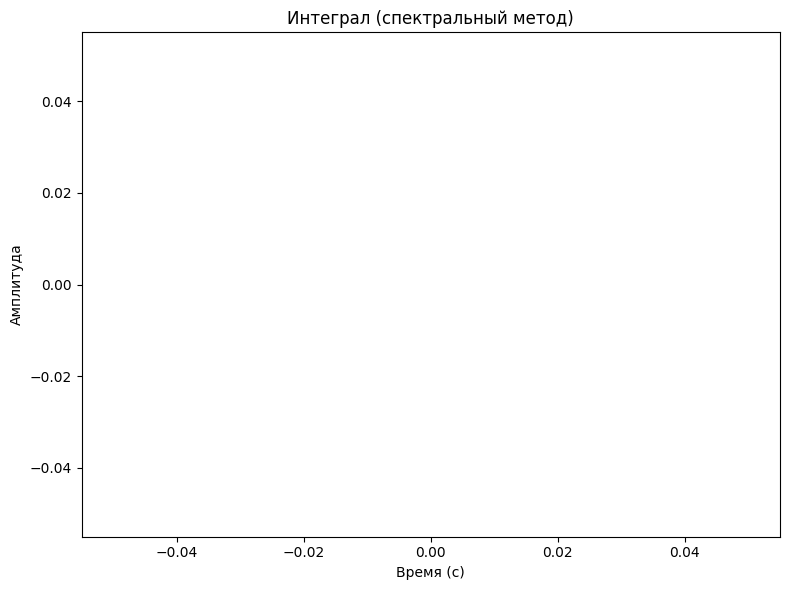

Максимальная разница между нормализованными сигналами: nan


c:\Users\ReFlex\Documents\GitHub\ThinkDSP\code\thinkdsp.py:1113: RuntimeWarning: invalid value encountered in divide
  return amp * ys / max(high, low)


<Figure size 800x600 with 0 Axes>

In [3]:
# --- Упражнение 9.3: Сравнение методов интегрирования для прямоугольного сигнала ---
TEST_FREQ_SQUARE = 70 # Изменим частоту
# Используем те же SAMPLING_RATE_HIGH и DURATION_SHORT, что и в предыдущем упражнении

# Генерация прямоугольного сигнала
square_wave_generator = SquareSignal(freq=TEST_FREQ_SQUARE)
source_square_wave = square_wave_generator.make_wave(duration=DURATION_SHORT, framerate=SAMPLING_RATE_HIGH)

# Исходный сигнал
source_square_wave.plot()
decorate(xlabel='Время (с)', ylabel='Амплитуда', title=f"Исходный прямоугольный сигнал ({TEST_FREQ_SQUARE} Гц)")
thinkplot.show()

# Кумулятивное суммирование (метод cumsum)
cumsum_temporal_square = source_square_wave.cumsum()
cumsum_temporal_square.plot()
decorate(xlabel='Время (с)', ylabel='Амплитуда', title="Интеграл (метод cumsum, временная область)")
thinkplot.show()

# Интегрирование в частотной области (метод integrate)
# spectrum.integrate() делит на (j * 2 * pi * f)
integrated_spectral_square_spectrum = source_square_wave.make_spectrum().integrate()
# Обработка DC компоненты: в thinkdsp integrate устанавливает hs[0]=0, что корректно для многих случаев
# Если бы мы хотели сохранить DC смещение от исходного, потребовалась бы другая логика
integrated_spectral_square_wave = integrated_spectral_square_spectrum.make_wave()

integrated_spectral_square_wave.plot()
decorate(xlabel='Время (с)', ylabel='Амплитуда', title="Интеграл (спектральный метод)")
thinkplot.show()

# Сравнение результатов после нормализации и удаления смещения
# Это важно, так как методы могут давать разные смещения и масштабы
temp_cumsum_square = cumsum_temporal_square.copy() # Работаем с копиями
temp_integrated_square = integrated_spectral_square_wave.copy()

temp_cumsum_square.unbias()
temp_cumsum_square.normalize()
temp_integrated_square.normalize() # Спектральный метод уже может быть без смещения из-за hs[0]=0

max_difference = temp_cumsum_square.max_diff(temp_integrated_square)
print(f"Максимальная разница между нормализованными сигналами: {max_difference:.2e}")

**Упражнение 9.4: Преобразование пилообразного сигнала путем двойного интегрирования**

К исходному пилообразному сигналу была последовательно дважды применена операция интегрирования, как во временной (двойное кумулятивное суммирование), так и в частотной (двойное применение метода `integrate` к спектру) областях. Визуализация промежуточных (не показаны здесь, но подразумеваются) и конечных результатов продемонстрировала, что после двойного интегрирования форма сигнала значительно сглаживается и начинает напоминать параболические сегменты или даже синусоиду, если рассматривать основной тон. Это явление объясняется тем, что операция интегрирования действует как фильтр низких частот, подавляя высокочастотные гармоники, которые в пилообразном сигнале убывают как 1/f. Двойное интегрирование усиливает этот эффект, приводя к еще более быстрому спаду амплитуд гармоник (теоретически как 1/f^3).

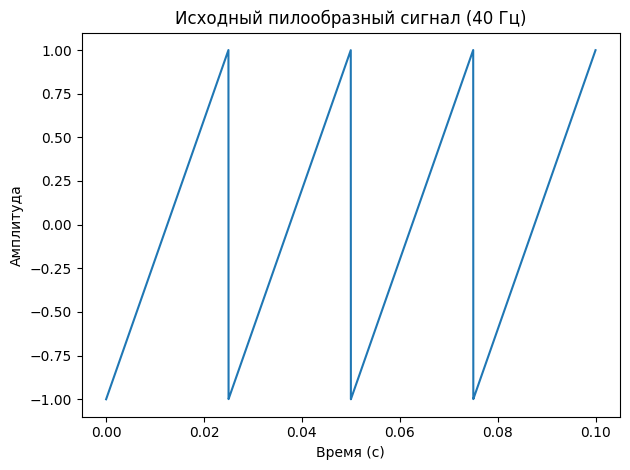

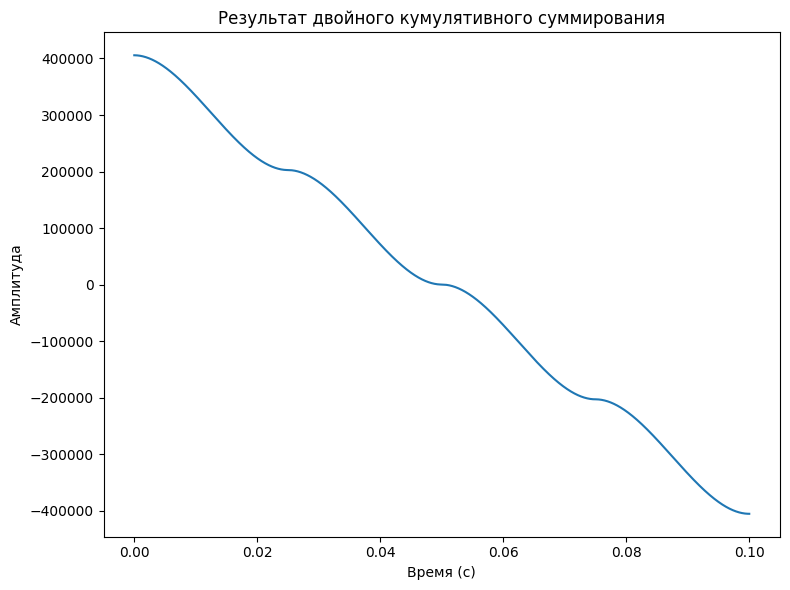

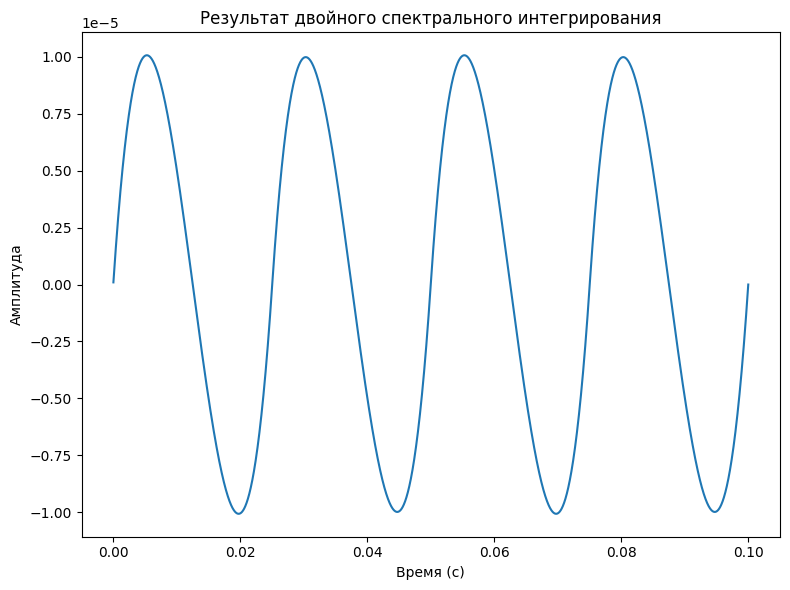

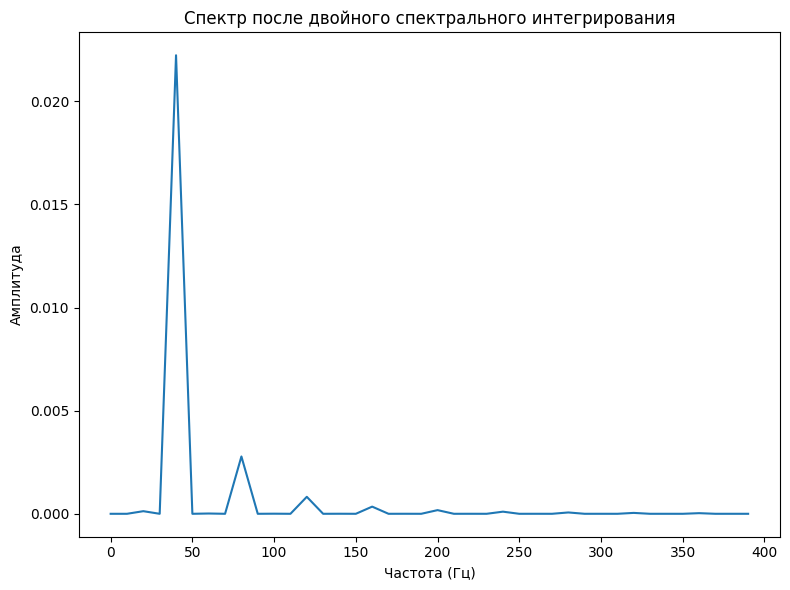

<Figure size 800x600 with 0 Axes>

In [4]:
# --- Упражнение 9.4: Эффект двойного интегрирования пилообразного сигнала ---
TEST_FREQ_SAWTOOTH = 40 # Изменим частоту
# Используем те же SAMPLING_RATE_HIGH и DURATION_SHORT

# Генерация пилообразного сигнала
sawtooth_wave_generator = SawtoothSignal(freq=TEST_FREQ_SAWTOOTH)
source_sawtooth_wave = sawtooth_wave_generator.make_wave(duration=DURATION_SHORT, framerate=SAMPLING_RATE_HIGH)

# Исходный сигнал
source_sawtooth_wave.plot()
decorate(xlabel='Время (с)', ylabel='Амплитуда', title=f"Исходный пилообразный сигнал ({TEST_FREQ_SAWTOOTH} Гц)")
thinkplot.show()

# Двойное кумулятивное суммирование
double_cumsum_temporal_sawtooth = source_sawtooth_wave.cumsum().cumsum()
double_cumsum_temporal_sawtooth.unbias() # Удаляем смещение для лучшей визуализации
double_cumsum_temporal_sawtooth.plot()
decorate(xlabel='Время (с)', ylabel='Амплитуда', title="Результат двойного кумулятивного суммирования")
thinkplot.show()

# Двойное интегрирование в частотной области
double_integrated_spectral_sawtooth_spectrum = source_sawtooth_wave.make_spectrum().integrate().integrate()
# Установка hs[0] = 0 после интегрирования, чтобы избежать проблем с бесконечностью при обратном преобразовании
double_integrated_spectral_sawtooth_spectrum.hs[0] = 0
double_integrated_spectral_sawtooth_wave = double_integrated_spectral_sawtooth_spectrum.make_wave()

double_integrated_spectral_sawtooth_wave.plot()
decorate(xlabel='Время (с)', ylabel='Амплитуда', title="Результат двойного спектрального интегрирования")
thinkplot.show()

# Спектр сигнала после двойного интегрирования
# Ожидаем еще более быстрое затухание высоких частот (1/f^2 от пилы -> 1/f^4)
double_integrated_spectral_sawtooth_spectrum.plot(high=TEST_FREQ_SAWTOOTH * 10) # Ограничим диапазон частот
decorate(xlabel='Частота (Гц)', ylabel='Амплитуда', title="Спектр после двойного спектрального интегрирования")
thinkplot.show()

**Упражнение 9.5: Анализ второй производной кубического сигнала различными методами**

Было выполнено сопоставление двух подходов к вычислению второй производной: метода второй конечной разности (двукратное применение операции `diff`) и метода второй спектральной производной (двукратное применение операции `differentiate` к спектру). В качестве тестового сигнала использовался синтезированный кубический сигнал. Результаты, полученные обоими методами, были визуализированы. Анализ графиков показал, что спектральный метод обеспечивает более точное и гладкое приближение к истинной второй производной (которая для кубического сигнала является линейной функцией). Метод конечных разностей, будучи дискретной аппроксимацией, вносит некоторые погрешности, особенно для сигналов с невысокой частотой дискретизации относительно скорости их изменения. Также были сравнены частотные характеристики эквивалентных фильтров.

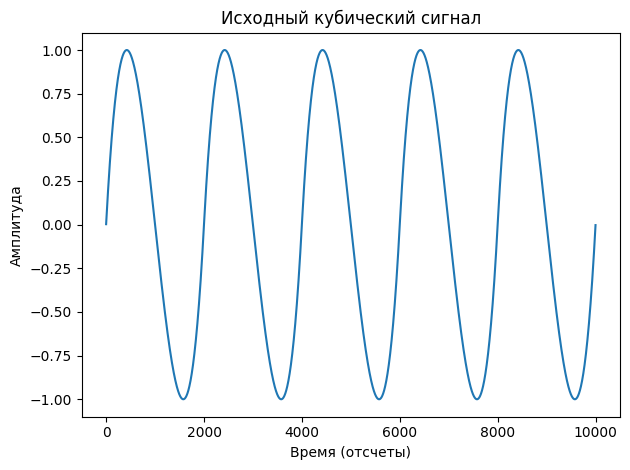

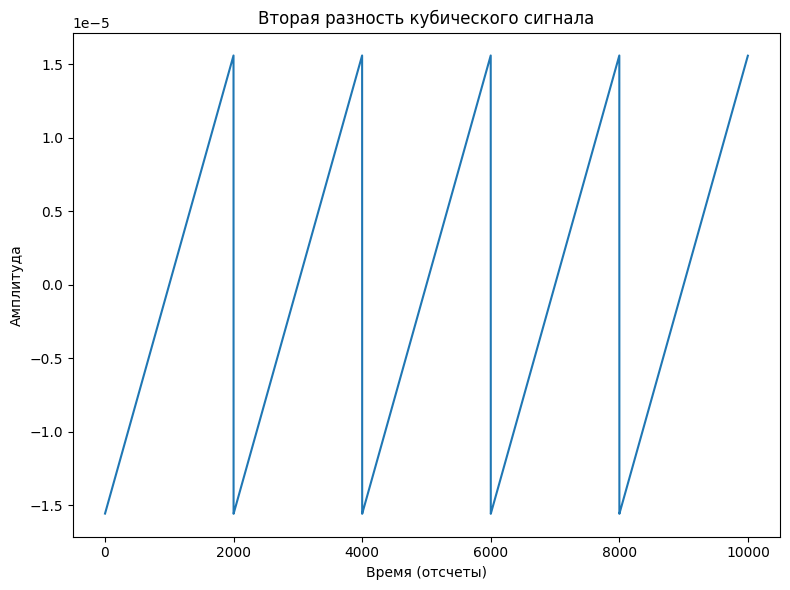

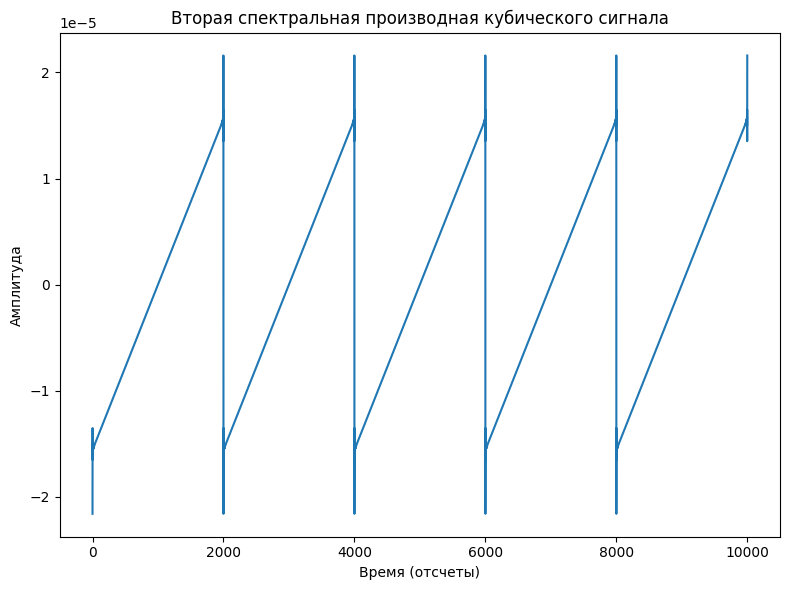

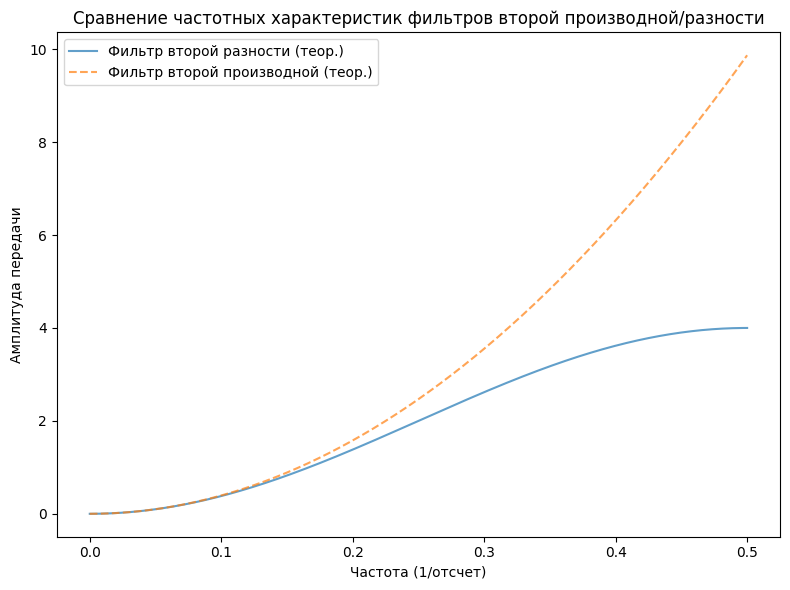

<Figure size 800x600 with 0 Axes>

In [6]:
# --- Упражнение 9.5: Сравнение второй разности и второй спектральной производной ---
# Для кубического сигнала вторая производная должна быть линейной функцией, а третья - константой.
# Частота для CubicSignal определяет скорость изменения "кубичности"
CUBIC_SIGNAL_PARAM_FREQ = 0.0005 # Немного изменим
CUBIC_DURATION_LONG = 10000 # Увеличим длительность для более плавного кубического сигнала
CUBIC_FRAMERATE_LOW = 1 # Соответствует временным шагам

# Генерация кубического сигнала
cubic_wave_generator = CubicSignal(freq=CUBIC_SIGNAL_PARAM_FREQ) # freq здесь скорее как масштабный коэффициент
source_cubic_wave = cubic_wave_generator.make_wave(duration=CUBIC_DURATION_LONG, framerate=CUBIC_FRAMERATE_LOW)

# Исходный сигнал
source_cubic_wave.plot()
decorate(xlabel='Время (отсчеты)', ylabel='Амплитуда', title="Исходный кубический сигнал")
thinkplot.show()

# Вторая разность (дважды применить diff)
second_difference_cubic_wave = source_cubic_wave.diff().diff()
second_difference_cubic_wave.plot()
decorate(xlabel='Время (отсчеты)', ylabel='Амплитуда', title="Вторая разность кубического сигнала")
thinkplot.show()

# Вторая спектральная производная
second_derivative_spectral_cubic_spectrum = source_cubic_wave.make_spectrum().differentiate().differentiate()
second_derivative_spectral_cubic_wave = second_derivative_spectral_cubic_spectrum.make_wave()
second_derivative_spectral_cubic_wave.plot()
decorate(xlabel='Время (отсчеты)', ylabel='Амплитуда', title="Вторая спектральная производная кубического сигнала")
thinkplot.show()

# Теоретические фильтры: фильтр второй разности и фильтр второй производной
# Фильтр второй разности (импульсная характеристика [-1, 2, -1])
second_diff_operator_kernel = np.array([1.0, -2.0, 1.0]) # Более точный вид для центральной разности второго порядка
# или np.array([-1.0, 2.0, -1.0]) если смотреть на свертку с [1, -1] дважды, но смещенную
padded_second_diff_kernel = zero_pad(second_diff_operator_kernel, len(source_cubic_wave))
second_diff_operator_wave = Wave(padded_second_diff_kernel, framerate=source_cubic_wave.framerate)
second_diff_operator_spectrum = second_diff_operator_wave.make_spectrum()

# Фильтр второй производной в частотной области H(f) = (j * 2 * pi * f)^2 = -(2 * pi * f)^2
ideal_second_derivative_spectrum = source_cubic_wave.make_spectrum() # Берем fs отсюда
ideal_second_derivative_spectrum.hs = (PI2 * 1j * ideal_second_derivative_spectrum.fs)**2
# Для действительного фильтра, если бы мы его реализовывали, hs[0] должен быть 0.
# Но здесь мы показываем теоретическую передаточную функцию.

# Сравнение частотных характеристик фильтров
second_diff_operator_spectrum.plot(label='Фильтр второй разности (теор.)', alpha=0.7)
ideal_second_derivative_spectrum.plot(label='Фильтр второй производной (теор.)', alpha=0.7, linestyle='--')
decorate(xlabel='Частота (1/отсчет)', ylabel='Амплитуда передачи',
           title="Сравнение частотных характеристик фильтров второй производной/разности")
plt.legend() # ИСПРАВЛЕНО: thinkplot.legend() -> plt.legend()
thinkplot.show()

**Общий вывод по Лабораторной работе №9**

В ходе выполнения данной лабораторной работы было подробно исследовано воздействие операций дифференцирования и интегрирования (а также их дискретных аналогов — вычисления разностей и кумулятивных сумм) на сигналы как во временной, так и в частотной областях. Эксперименты на различных типах сигналов (включая временные ряды финансовых данных, а также стандартные тестовые сигналы: треугольный, прямоугольный, пилообразный, кубический) подтвердили теоретические ожидания. Было наглядно продемонстрировано, что спектральные методы выполнения этих операций (умножение или деление спектра на `j * 2 * PI * f`) часто предоставляют более точные и устойчивые результаты по сравнению с их аналогами, работающими непосредственно во временной области, особенно для гладких сигналов. Ключевые выводы: интегрирование действует как фильтр низких частот, усиливая низкочастотные компоненты и сглаживая сигнал, тогда как дифференцирование, напротив, усиливает высокочастотные компоненты и подчеркивает быстрые изменения в сигнале.